In [2]:
pip install nba_api

Note: you may need to restart the kernel to use updated packages.


In [8]:
from nba_api.stats.endpoints import shotchartdetail
import pandas as pd

In [131]:
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.static import teams
import pandas as pd
import time

# -----------------------------------
# 1. Find Warriors team_id
# -----------------------------------
nba_teams = teams.get_teams()
warriors = [team for team in nba_teams if team['full_name'] == 'Golden State Warriors'][0]
team_id = warriors['id']

# -----------------------------------
# 2. List the seasons (NBA season format: 'YYYY-YY')
# -----------------------------------
seasons = [f"{year}-{str(year+1)[-2:]}" for year in range(2015, 2025)]  # 2015-16 to 2024-25

# -----------------------------------
# 3. Loop through each season, pull all shots, and stack
# -----------------------------------
all_shots = []

for season in seasons:
    print(f"Pulling data for {season}...")
    try:
        # NBA API can be rate-limited. Add a short pause between calls.
        shotchart = shotchartdetail.ShotChartDetail(
            team_id=team_id,
            player_id=0,  # 0 = all players
            season_type_all_star='Regular Season',
            season_nullable=season,
            context_measure_simple='FGA'
        )
        data = shotchart.get_data_frames()[0]
        data['SEASON'] = season  # Add season info for later
        all_shots.append(data)
        time.sleep(1)  # Pause to avoid rate limits
    except Exception as e:
        print(f"Failed for {season}: {e}")
        time.sleep(3)  # Longer pause on error

# -----------------------------------
# 4. Combine into one DataFrame
# -----------------------------------
df_all = pd.concat(all_shots, ignore_index=True)

# -----------------------------------
# 5. Save or preview the data
# -----------------------------------
print(f"Total shots in all seasons: {len(df_all)}")
print(df_all.head())
df_all.to_csv('warriors_shots_2015_2025.csv', index=False)

Pulling data for 2015-16...
Pulling data for 2016-17...
Pulling data for 2017-18...
Pulling data for 2018-19...
Pulling data for 2019-20...
Pulling data for 2020-21...
Pulling data for 2021-22...
Pulling data for 2022-23...
Pulling data for 2023-24...
Pulling data for 2024-25...
Total shots in all seasons: 70118
           GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID     PLAYER_NAME  \
0  Shot Chart Detail  0021500003              4     203110  Draymond Green   
1  Shot Chart Detail  0021500003              6     201939   Stephen Curry   
2  Shot Chart Detail  0021500003              9     201939   Stephen Curry   
3  Shot Chart Detail  0021500003             14     201939   Stephen Curry   
4  Shot Chart Detail  0021500003             15     101106    Andrew Bogut   

      TEAM_ID              TEAM_NAME  PERIOD  MINUTES_REMAINING  \
0  1610612744  Golden State Warriors       1                 11   
1  1610612744  Golden State Warriors       1                 10   
2  1610612744  G

/var/folders/rc/wjcykm9d6ms_dr3jsr0nczdh0000gn/T/ipykernel_18738/457397558.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Shot Type', loc='upper right')


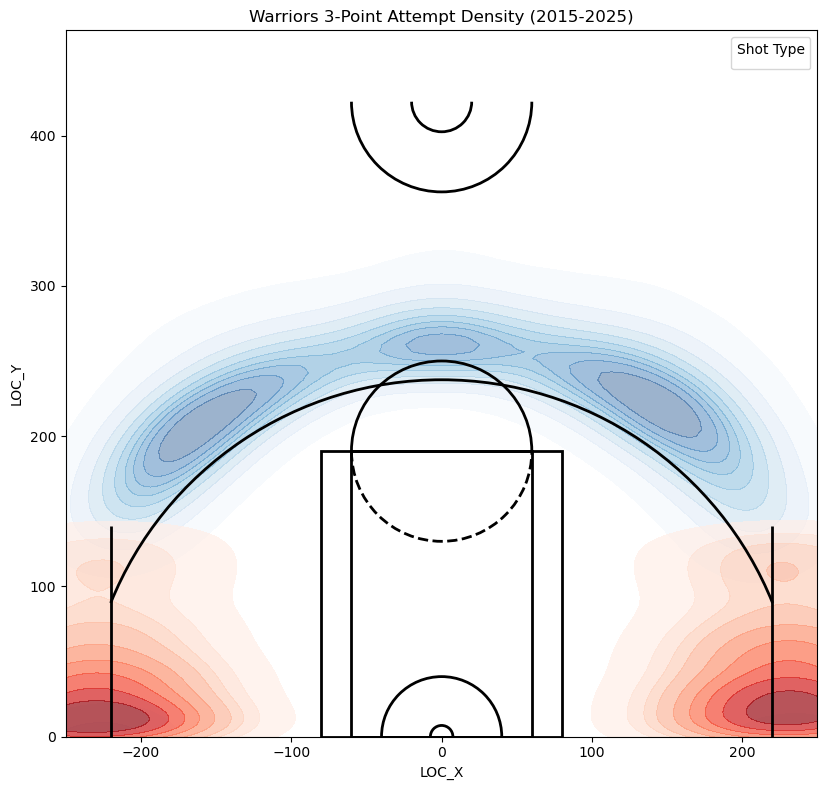

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume draw_court(color='black') is already defined in your notebook

plt.figure(figsize=(10, 8))
ax = plt.gca()

# Non-corner threes: blue
non_corner_plot = sns.kdeplot(
    x=df_all.loc[non_corner_mask, 'LOC_X'],
    y=df_all.loc[non_corner_mask, 'LOC_Y'],
    fill=True,
    alpha=0.4,
    cmap='Blues',
    thresh=0.05,
    ax=ax,
    label='Non-Corner Threes'
)

# Corner threes: red
corner_plot = sns.kdeplot(
    x=df_all.loc[corner_mask, 'LOC_X'],
    y=df_all.loc[corner_mask, 'LOC_Y'],
    fill=True,
    alpha=0.7,
    cmap='Reds',
    thresh=0.05,
    ax=ax,
    label='Corner Threes'
)

draw_court(ax=ax, color='black')
plt.title('Warriors 3-Point Attempt Density (2015-2025)')
plt.xlabel('LOC_X')
plt.ylabel('LOC_Y')
plt.legend(title='Shot Type', loc='upper right')
plt.tight_layout()
plt.show()


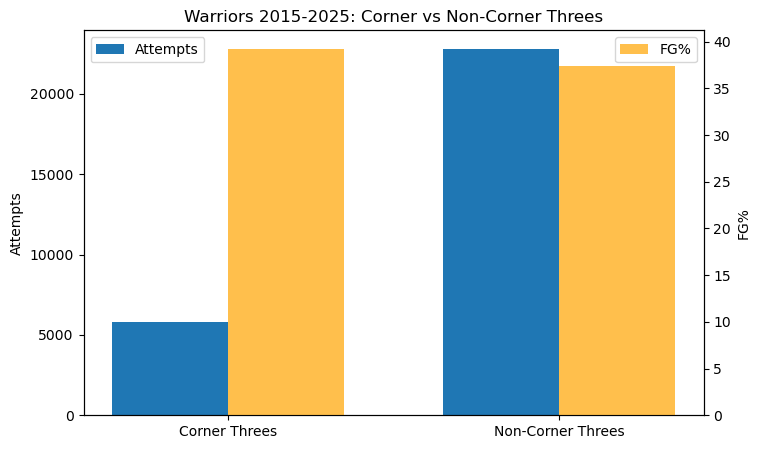

In [53]:
import numpy as np

labels = ['Corner Threes', 'Non-Corner Threes']
attempts = [corner_mask.sum(), non_corner_mask.sum()]
percentages = [
    df_all.loc[corner_mask, 'SHOT_MADE_FLAG'].mean() * 100,
    df_all.loc[non_corner_mask, 'SHOT_MADE_FLAG'].mean() * 100
]

x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 5))
bar1 = ax1.bar(x - width/2, attempts, width, label='Attempts')
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, percentages, width, label='FG%', color='orange', alpha=0.7)

ax1.set_ylabel('Attempts')
ax2.set_ylabel('FG%')
plt.xticks(x, labels)
ax1.set_title('Warriors 2015-2025: Corner vs Non-Corner Threes')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()